*   Bidrection to SimpleRNN
*  Change Batch_size
*  Change Learning Rate

Huber Loss: loss function used in robust regression, it is less sensitive to outliers in data than the squared error loss.

**Recurrent Neural Networks**: Using for modeling sequence data. Processes the sequences of vectors one by one, while processing, it passes the previous hidden state to the next sequence. The hidden state holds information on previous data.
 ex) moving prediction, text prediction
- Vanishing gradient: during back propagation, gradients supposed to update neural netowrk weights. Gradients shrinks as it back propagate through time and extremly small gradients, learning becomes meaningless and stop.
> **New weight = weight - (learning_rate*gradient)**

As a solution to the vanishing gradient problem, there are two specialized RNN. 
1.   **GRU(Gate Recurrent Units)**: get rid of cell state and used the hidden state to transfer information. It can goes either Reset gate or Update gate. 
2.   **LSTM(Long Short Term Memory)**: acts as cell state transport information. As the cell state goes, information can be added or removed to the cell state via gates. The gates decide whether the information is relevant or not. Gates contains sigmoid activation(0-1)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
  
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Model 1
- learning rate: 1e-8 to 5e-5
- batch size: 128
- SimpleRNN(40)

In [ ]:
tf.keras.backend.clear_session() #clear out all temporary variables that tensorflow might have from previous sessions
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 201.2636 - mae: 201.7634
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 200.3801 - mae: 200.8797
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 198.9616 - mae: 199.4613
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 197.1741 - mae: 197.6741
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 195.0691 - mae: 195.5691
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 192.6585 - mae: 193.1585
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 189.8953 - mae: 190.3953
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 186.7408 - mae: 187.2408
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 183.1527 - mae: 183.6527
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 179.0401 - mae: 179.5401
Epoch 11/100
8/8 [===========

(1e-08, 0.0001, 0.0, 30.0)

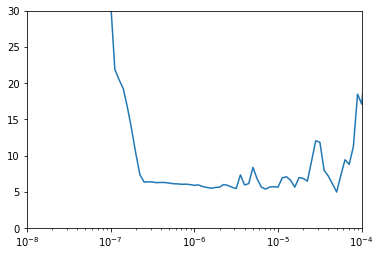

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

The graph looks unstable from 5e-5. so we will take it as a new desire learning rate.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100) #400

Epoch 1/400
8/8 [==============================] - 0s 12ms/step - loss: 81.9276 - mae: 82.4275
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 21.6719 - mae: 22.1652
Epoch 3/400
8/8 [==============================] - 0s 11ms/step - loss: 14.7060 - mae: 15.1978
Epoch 4/400
8/8 [==============================] - 0s 12ms/step - loss: 9.6177 - mae: 10.1063
Epoch 5/400
8/8 [==============================] - 0s 11ms/step - loss: 11.1583 - mae: 11.6512
Epoch 6/400
8/8 [==============================] - 0s 12ms/step - loss: 10.9273 - mae: 11.4187
Epoch 7/400
8/8 [==============================] - 0s 13ms/step - loss: 13.3949 - mae: 13.8879
Epoch 8/400
8/8 [==============================] - 0s 12ms/step - loss: 12.2428 - mae: 12.7341
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 12.2576 - mae: 12.7534
Epoch 10/400
8/8 [==============================] - 0s 12ms/step - loss: 10.5858 - mae: 11.0751
Epoch 11/400
8/8 [==============================] 

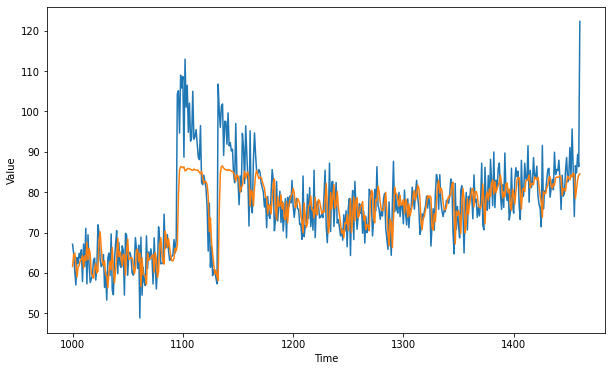

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.427662

We can see huge improvement on our model. 

# Model 2
- SimpleRNN(40) --> Bidrectional(LSTM,32)
- Learning rate: 1e-5
- Number of Bidrection LSTM layers can be change 1 or 2 or 
- Loss: Huber() --> "mse"

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=0)#500

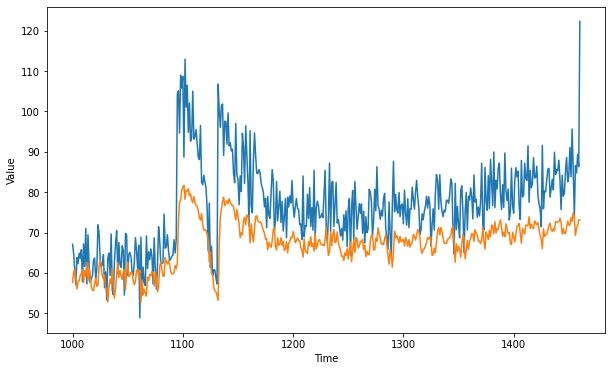

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.762059

<Figure size 432x288 with 0 Axes>

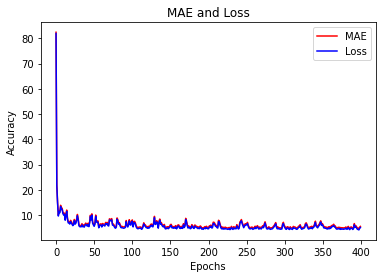

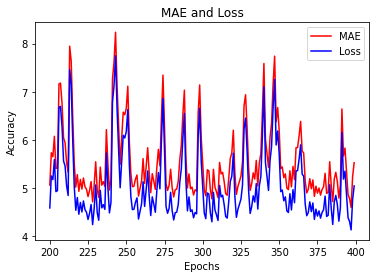

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

MAE is bigger, overfitting the model. There are lot of noise. A small batch size introducing further random noise. We can try to use 16 batch size instead of 32.